In [6]:
!pip install seaborn

     ------------------------------------ 294.9/294.9 kB 759.1 kB/s eta 0:00:00
     ---------------------------------------- 11.3/11.3 MB 3.7 MB/s eta 0:00:00
     -------------------------------------- 509.2/509.2 kB 7.9 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# fix random seeds for reproducibility (optional)
np.random.seed(42)
tf.random.set_seed(42)



In [8]:
!pip install scikit-learn


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
dataset_path = "DataSet/Data"   # change if different
print("Folders in dataset:", os.listdir(dataset_path))
print("WithMask count:", len(os.listdir(os.path.join(dataset_path, "with_mask"))))
print("WithoutMask count:", len(os.listdir(os.path.join(dataset_path, "without_mask"))))


Folders in dataset: ['without_mask', 'with_mask']
WithMask count: 3725
WithoutMask count: 3828


In [4]:
IMG_SIZE = (224, 224)   # MobileNetV2 prefers 224
BATCH_SIZE = 32
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)

print("Class indices:", train_gen.class_indices)
# count samples per class from generator
from collections import Counter
print("Train class counts:", Counter(train_gen.classes))
print("Val class counts:", Counter(val_gen.classes))


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Class indices: {'with_mask': 0, 'without_mask': 1}
Train class counts: Counter({1: 3063, 0: 2980})
Val class counts: Counter({1: 765, 0: 745})


In [5]:
# compute class weights automatically
classes = train_gen.classes  # labels for training set
cw = class_weight.compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weights = {i: cw[i] for i in range(len(cw))}
print("Class weights:", class_weights)


Class weights: {0: 1.0139261744966444, 1: 0.9864511916421809}


In [6]:
base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))

# freeze base
for layer in base.layers:
    layer.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3300\312499965.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
EPOCHS = 12

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_mask_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.9797 - loss: 0.0607
Epoch 1: val_loss improved from None to 0.05167, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9770 - loss: 0.0673 - val_accuracy: 0.9795 - val_loss: 0.0517
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9806 - loss: 0.0579
Epoch 2: val_loss improved from 0.05167 to 0.05139, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9778 - loss: 0.0606 - val_accuracy: 0.9821 - val_loss: 0.0514
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9803 - loss: 0.0513
Epoch 3: val_loss improved from 0.05139 to 0.04705, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 186s 984ms/step - accuracy: 0.9790 - loss: 0.0565 - val_accuracy: 0.9834 - val_loss: 0.0471
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9844 - loss: 0.0454
Epoch 4: val_loss improved from 0.04705 to 0.04553, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 188s 994ms/step - accuracy: 0.9816 - loss: 0.0497 - val_accuracy: 0.9834 - val_loss: 0.0455
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9803 - loss: 0.0515
Epoch 5: val_loss did not improve from 0.04553
189/189 ━━━━━━━━━━━━━━━━━━━━ 186s 983ms/step - accuracy: 0.9798 - loss: 0.0529 - val_accuracy: 0.9781 - val_loss: 0.0499
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.9845 - loss: 0.0432
Epoch 6: val_loss did not improve from 0.04553
189/189 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9825 - loss: 0.0467 - val_accuracy: 0.9861 - val_loss: 0.0471
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9817 - loss: 0.0503
Epoch 7: val_loss improved from 0.04553 to 0.04364, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9828 - loss: 0.0461 - val_accuracy: 0.9868 - val_loss: 0.0436
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.9832 - loss: 0.0431
Epoch 8: val_loss improved from 0.04364 to 0.03953, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9856 - loss: 0.0406 - val_accuracy: 0.9854 - val_loss: 0.0395
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.9834 - loss: 0.0478
Epoch 9: val_loss improved from 0.03953 to 0.03714, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9831 - loss: 0.0453 - val_accuracy: 0.9894 - val_loss: 0.0371
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.9814 - loss: 0.0487
Epoch 10: val_loss did not improve from 0.03714
189/189 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9813 - loss: 0.0495 - val_accuracy: 0.9841 - val_loss: 0.0405
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9889 - loss: 0.0347
Epoch 11: val_loss did not improve from 0.03714
189/189 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9869 - loss: 0.0373 - val_accuracy: 0.9868 - val_loss: 0.0409
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9843 - loss: 0.0383
Epoch 12: val_loss did not improve from 0.03714
189/189 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9849 - loss: 0.0396 - val_accuracy: 0.9881 - val_loss: 0.0399
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 9.


In [9]:
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc * 100:.2f}%")


48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 847ms/step - accuracy: 0.9834 - loss: 0.0446
Validation Accuracy: 98.34%


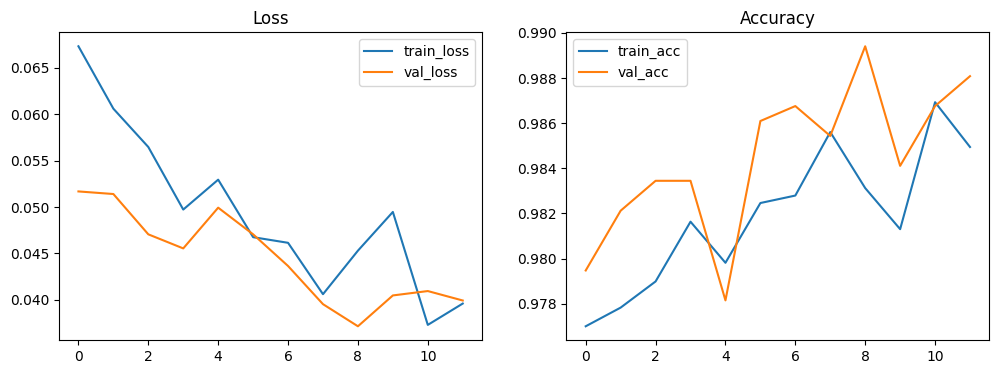

In [10]:


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 807ms/step


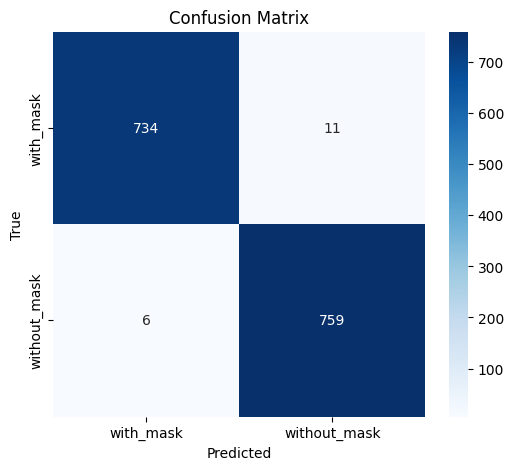

Classification Report:

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       765

    accuracy                           0.99      1510
   macro avg       0.99      0.99      0.99      1510
weighted avg       0.99      0.99      0.99      1510



In [11]:
# get predictions on validation set
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = val_gen.classes  # ground truth from generator

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(train_gen.class_indices.keys())  # maps integer -> folder name order is by class_indices keys
# But class_indices maps name->int; we need names in order of 0..n-1
inv_map = {v:k for k,v in train_gen.class_indices.items()}
ordered_labels = [inv_map[i] for i in range(len(inv_map))]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ordered_labels, yticklabels=ordered_labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=ordered_labels))


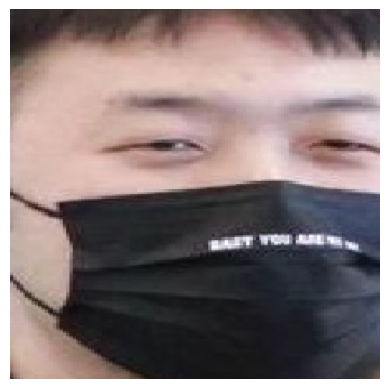

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: with_mask  |  Confidence: 1.000  |  Raw score: 0.0001


In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# derive mapping from model class indices dictionary
inv_map = {v:k for k,v in train_gen.class_indices.items()}

def predict_mask(img_path, show_image=True):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    if show_image:
        plt.imshow(img); plt.axis('off'); plt.show()
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)[0][0]
    label_index = 1 if pred>0.5 else 0
    label_name = inv_map[label_index]
    conf = pred if label_index==1 else 1-pred  # confidence for chosen class
    print(f"Prediction: {label_name}  |  Confidence: {conf:.3f}  |  Raw score: {pred:.4f}")

# Example usage:
predict_mask("dataSet/data/with_mask/with_mask_199.jpg")


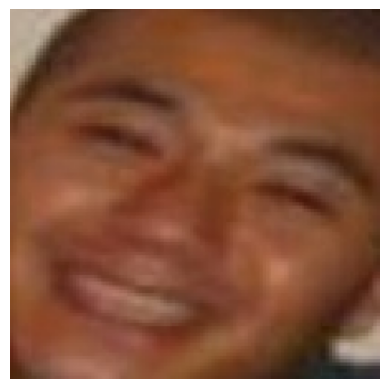

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: without_mask  |  Confidence: 0.998  |  Raw score: 0.9980


In [16]:
predict_mask("dataSet/data/without_mask/without_mask_199.jpg")

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load your trained model
model = load_model('best_mask_model.h5')

# Load OpenCV's pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("❌ Error: Could not open camera.")
    exit()
else:
    print("✅ Camera opened successfully. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Failed to grab frame.")
        break

    # Flip the frame horizontally for natural view
    frame = cv2.flip(frame, 1)

    # Convert frame to grayscale (for face detection)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

    for (x, y, w, h) in faces:
        # Extract face ROI
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face) / 255.0
        face = np.expand_dims(face, axis=0)

        # Model prediction
        pred = model.predict(face)[0][0]
        confidence = (1 - pred) * 100 if pred < 0.5 else pred * 100

        if pred < 0.5:
            label = f"😷 With Mask ({confidence:.1f}%)"
            color = (0, 255, 0)  # Green
        else:
            label = f"🙅 Without Mask ({confidence:.1f}%)"
            color = (0, 0, 255)  # Red

        # Draw rectangle and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show result
    cv2.imshow("🧠 Real-Time Face Mask Detection", frame)

    # Quit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
